# EMA für Swing Trader - Trendfolger

## Bedingungen

Die Strategie basiert auf einen starken Trend, der mit Hilfe des ADX Indikators identifiziert wird. Der ADX lässt sich wie folgt unterteilen:
- unter 20 - schwachen Trend oder Seitwärtsbewegung
- zwischen 20 und 40 - moderaten Trend oder start eines Trends
- über 40 - starken Trend 

### Long Signal
Es entsteht ein Signal wenn:
- ADX ist über 25
- Der EMA 10 befindet sich über dem EMA 20
- Der Kurs (Low) den EMA 10 berührt  

### Short Signal
Es entsteht ein Signal wenn:
- ADX ist über 25
- Der EMA befindet sich unter dem EMA 20
- Der Kurs (High) den EMA 10  


In [1]:
import yfinance as yf
import backtesting as bt
from tiny_ta import ema, atr
import numpy as np
import pandas_ta as ta
import mplfinance as mpf

In [2]:
stock = yf.download("^GSPC", start="2022-01-01")
stock["ema_10"] = ema(stock.Close, 10)
stock["ema_20"] = ema(stock.Close, 30)

stock["adx"] = ta.adx(stock.High, stock.Low, stock.Close)["ADX_14"]
stock["atr_200"] = atr(stock, 200, smoothing="rma")

[*********************100%%**********************]  1 of 1 completed


In [3]:
adx_trigger = 25

# ema reversal
stock["reversal_long"] = (
    (stock.Open < stock.Close)
    & (stock.ema_10 > stock.ema_20)
    & (stock.High > stock.ema_10)
    & (stock.Low < stock.ema_10)
    & (stock.adx > adx_trigger)
)


stock["reversal_short"] = (
    (stock.Open > stock.Close)
    & (stock.ema_10 < stock.ema_20)
    & (stock.High > stock.ema_10)
    & (stock.Low < stock.ema_10)
    & (stock.adx > adx_trigger)
)

stock["buy_signal"] = stock[stock.reversal_long == True]["Low"]
stock["sell_signal"] = stock[stock.reversal_short == True]["High"]

stock["buy_sl"] = (
    stock[stock.reversal_long == True]["Low"]
    - stock[stock.reversal_long == True]["atr_200"]
)
stock["sell_sl"] = (
    stock[stock.reversal_short == True]["High"]
    + stock[stock.reversal_short == True]["atr_200"]
)
stock["buy_tp"] = (
    stock[stock.reversal_long == True]["High"]
    + 3 * stock[stock.reversal_long == True]["atr_200"]
)
stock["sell_tp"] = (
    stock[stock.reversal_short == True]["Low"]
    - 3 * stock[stock.reversal_short == True]["atr_200"]
)

In [4]:
stock["2023-06-01":].sell_signal.sum() > 0

False

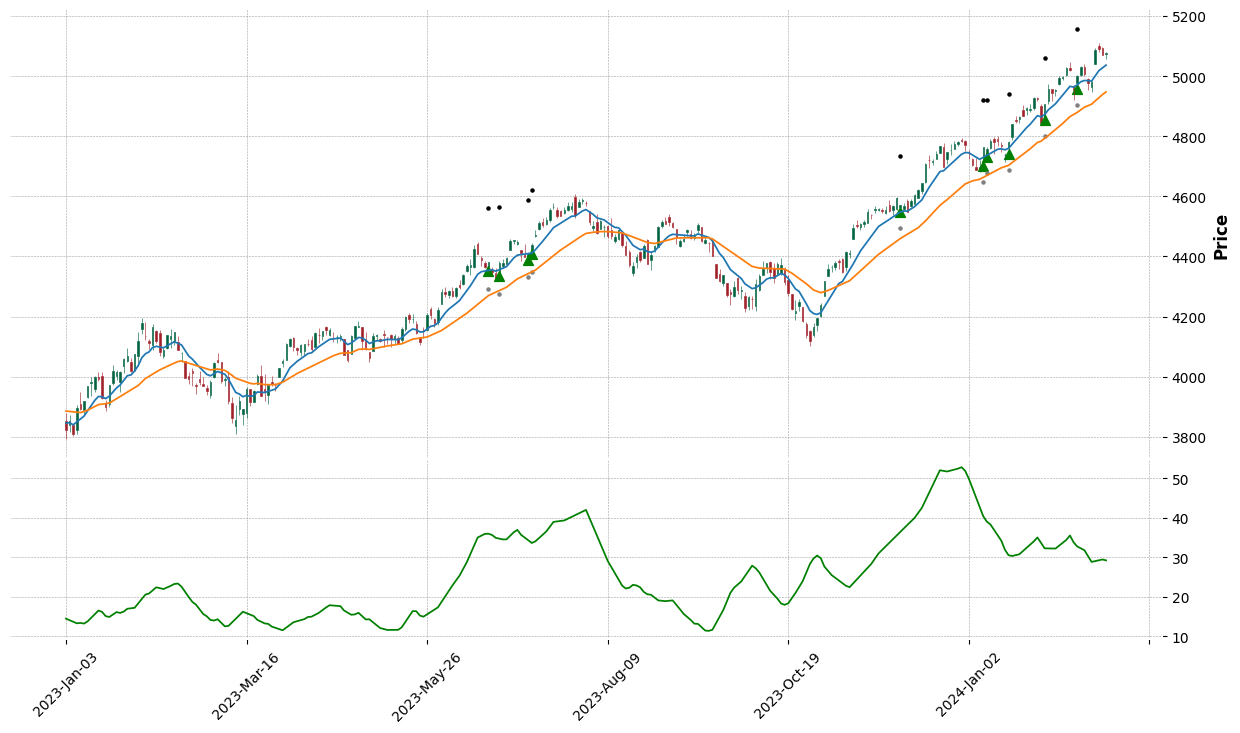

In [5]:
# output = stock[-255:]
output = stock["2023-01-01":]
apdict = [
    mpf.make_addplot(output["ema_10"]),
    mpf.make_addplot(output["ema_20"]),
    mpf.make_addplot(output["adx"], panel=1, color="g"),
]

if output.buy_signal.sum() > 0:
    apdict += [
        mpf.make_addplot(
            output["buy_signal"], type="scatter", markersize=50, marker="^", color="g"
        ),
        mpf.make_addplot(output["buy_sl"], type="scatter", markersize=5, color="grey"),
        mpf.make_addplot(output["buy_tp"], type="scatter", markersize=5, color="black"),
    ]

if output.sell_signal.sum() > 0:
    apdict += [
        mpf.make_addplot(
            output["sell_signal"], type="scatter", markersize=50, marker="v", color="r"
        ),
        mpf.make_addplot(output["sell_sl"], type="scatter", markersize=5, color="grey"),
        mpf.make_addplot(
            output["sell_tp"], type="scatter", markersize=5, color="black"
        ),
    ]

mpf.plot(output, addplot=apdict, figsize=(16, 9), style="charles", type="candle")

In [6]:
from backtesting import Strategy


class trend_trading(Strategy):
    """
    strategy for trend_trading
    """

    def ohlc(self, pos=-1) -> tuple:
        """
        helper function for ohlc data
        """
        return (
            self.data.Open[pos],
            self.data.High[pos],
            self.data.Low[pos],
            self.data.Close[pos],
        )

    def init(self):
        super().init()

        self.ema_10 = self.I(lambda: self.data.ema_10, name=f"EMA 10")
        self.ema_20 = self.I(lambda: self.data.ema_20, name=f"EMA 20")
        self.adx = self.I(lambda: self.data.adx, name=f"ADX", overlay=False)
        self.atr = self.I(lambda: self.data.atr_200, name=f"ATR", plot=False)

        self.reversal_long = self.I(
            lambda: self.data.reversal_long, name=f"reversal_long", plot=False
        )
        self.reversal_short = self.I(
            lambda: self.data.reversal_short, name=f"reversal_short", plot=False
        )

        # long signal
        self.buy_signal = self.I(
            lambda: self.data.buy_signal,
            overlay=True,
            name=f"buy_signal",
            scatter=True,
            color="green",
        )

        # short signals
        self.sell_signal = self.I(
            lambda: self.data.sell_signal,
            overlay=True,
            name=f"sell_signal",
            scatter=True,
            color="red",
        )

    def next(self):
        super().next()

        _open, _high, _low, _close = self.ohlc()
        _atr = self.atr[-1]

        # cancel open order if current SL is triggert
        if len(self.orders) > 0:
            if not self.orders[-1].is_contingent:
                if self.orders[-1].is_long:
                    if self.orders[-1].sl > _low:
                        print("cancel")
                        self.orders[-1].cancel()
                elif self.orders[-1].is_short:
                    if self.orders[-1].sl > _high:
                        print("cancel")
                        self.orders[-1].cancel()

        # trade management for an existing trade
        if self.position.is_long:
            # duration = len(self.data) - self.trades[-1].entry_bar

            # reduce risk, if trade is 3% positive
            if self.trades[-1].pl_pct > 0.03:
                self.trades[-1].sl = max(
                    self.trades[-1].sl, self.trades[-1].entry_price
                )
        # prepare new order
        # else:
        SIZE = 0.5

        BUY_KK = _high
        BUY_SL = _low - _atr
        BUY_TP = _high + 3 * _atr

        SELL_KK = _low
        SELL_SL = _high + _atr
        SELL_TP = _low - 3 * _atr

        if self.reversal_long[-1]:
            self.buy(size=SIZE, stop=BUY_KK, sl=BUY_SL, tp=BUY_TP)

        if self.reversal_short[-1]:
            self.sell(size=SIZE, stop=SELL_KK, sl=SELL_SL, tp=SELL_TP)

In [7]:
from backtesting import Backtest

bt = Backtest(stock["2022-01-01":], trend_trading, cash=100_000, commission=0.002)
stats = bt.run()
bt.plot(superimpose=False, open_browser=False)

Row(id='1532', ...)

In [8]:
stats

Start                     2022-01-03 00:00:00
End                       2024-02-27 00:00:00
Duration                    785 days 00:00:00
Exposure Time [%]                    15.37037
Equity Final [$]                106196.963711
Equity Peak [$]                 106267.962246
Return [%]                           6.196964
Buy & Hold Return [%]                5.871293
Return (Ann.) [%]                    2.845584
Volatility (Ann.) [%]                2.564371
Sharpe Ratio                         1.109661
Sortino Ratio                        1.785986
Calmar Ratio                         0.969541
Max. Drawdown [%]                   -2.934979
Avg. Drawdown [%]                   -0.499685
Max. Drawdown Duration      272 days 00:00:00
Avg. Drawdown Duration       35 days 00:00:00
# Trades                                   12
Win Rate [%]                             75.0
Best Trade [%]                       3.930016
Worst Trade [%]                     -4.219546
Avg. Trade [%]                    